<a href="https://colab.research.google.com/github/jinaypanchal/StockRecommendationSytem-with-Portfolio-Optimization/blob/main/Stock_Recommendation_with_Portfolio_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Installing the necessary Libraries
!pip install yfinance
!pip install ta
!pip install tqdm


  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29089 sha256=8a335bb186dbfeac506acb553a0ac5b7934a2a58f5520bd749cdbf7bf484d6a7
  Stored in directory: /root/.cache/pip/wheels/47/51/06/380dc516ea78621870b93ff65527c251afdfdc5fa9d7f4d248
Successfully built ta


In [3]:
#Imports
import pandas as pd
import ta as ta
import numpy as np
from datetime import datetime
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

import pandas_datareader as pdr
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, date
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, ParameterGrid, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from collections import Counter

from sklearn import metrics
from sklearn.metrics import accuracy_score, r2_score, classification_report
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

from tqdm import tqdm

from tensorflow import keras
from tensorflow.keras import layers

#Hide runtime warnings
import warnings
warnings.filterwarnings('ignore')

## Data Preprocessing

In [4]:
# Define the list of tickers
tickers = [
    'NVDA',
    'BLK',
    'TCEHY',
    'AAPL',
    'MSFT',
    'AMZN',
    'TSLA',
    'BRK-B',
    'GOOGL',
    'XOM',
    'JNJ',
    'JPM',
]

# Download data using yfinance
stocks = []
for ticker in tickers:
    stock = yf.download(ticker, start="2021-12-01", end="2023-08-31")
    stocks.append(stock)

# Define a function to add technical indicators
def add_technical_indicators(data):
    data['RSI'] = ta.momentum.RSIIndicator(data['Adj Close'], window=14, fillna=True).rsi()
    data['SO'] = ta.momentum.StochRSIIndicator(data['Adj Close'], window=14, fillna=True).stochrsi()
    data['SMA'] = ta.trend.sma_indicator(data['Adj Close'], window=14, fillna=True)
    data['MACD'] = ta.trend.macd(data['Adj Close'], window_slow=26, window_fast=12, fillna=True)
    data['ROC'] = ta.momentum.ROCIndicator(data['Adj Close'], window=14, fillna=True).roc()
    data['OBV'] = ta.volume.OnBalanceVolumeIndicator(close=data['Adj Close'], volume=data['Volume'], fillna=True).on_balance_volume()

# Add technical indicators to all stocks
for stock in stocks:
    add_technical_indicators(stock)

# Define a function to add labels
def add_labels(data, lookback_period, label_column):
    data[label_column] = data['Adj Close'].diff(-lookback_period) * -1
    data[label_column] = data[label_column].apply(lambda x: 1 if x >= 0 else 0)

# Add labels for both 5-day and 20-day prediction
lookback_5d = 5
lookback_20d = 20

label_column_5d = '5d_label'
label_column_20d = '20d_label'

for stock in stocks:
    add_labels(stock, lookback_5d, label_column_5d)
    add_labels(stock, lookback_20d, label_column_20d)


feature_names = ['RSI', 'SO', 'SMA', 'MACD', 'ROC', 'OBV']

# Preprocessing and Scaling
def preprocess_and_scale(data, feature_columns, label_column, test_size=0.2):
    data = data.dropna()
    X = data[feature_columns]
    y = data[label_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, shuffle=False)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test

# Preprocess and scale for 5-day prediction
X_train_5d = []
y_train_5d = []
X_test_5d = []
y_test_5d = []

for stock in stocks:
    X_train, X_test, y_train, y_test = preprocess_and_scale(stock, feature_names, label_column_5d)
    X_train_5d.append(X_train)
    y_train_5d.append(y_train)
    X_test_5d.append(X_test)
    y_test_5d.append(y_test)

# Preprocess and scale for 20-day prediction
X_train_20d = []
y_train_20d = []
X_test_20d = []
y_test_20d = []

for stock in stocks:
    X_train, X_test, y_train, y_test = preprocess_and_scale(stock, feature_names, label_column_20d)
    X_train_20d.append(X_train)
    y_train_20d.append(y_train)
    X_test_20d.append(X_test)
    y_test_20d.append(y_test)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [5]:
print(len(X_train_5d))
print(len(y_train_5d))
print(len(X_test_5d))
print(len(y_test_5d))
print(stock.shape)

12
12
12
12
(439, 14)


# Data Analysis and Visualization

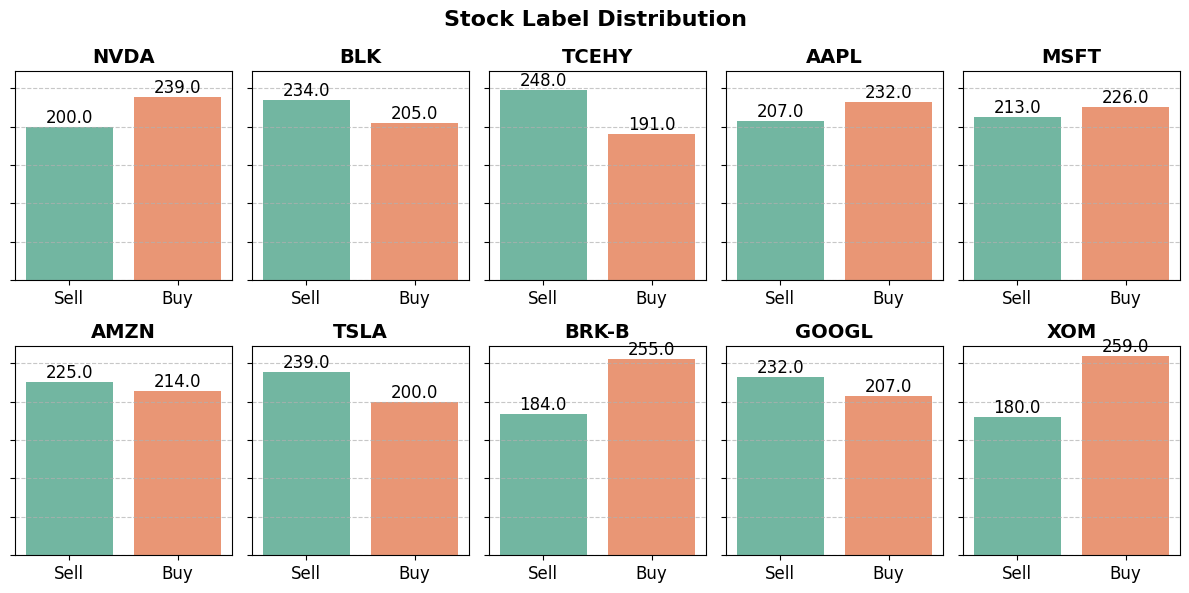

In [6]:
color_palette = sns.color_palette("Set2")

y_5d = [stock['5d_label'] for stock in stocks]
# print(y_5d)

# Create a grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6), sharey=True)

# Iterate through stocks and plot
for stock, stock_y5d, ax in zip(tickers, y_5d, axes.flatten()):
    distribution_5d = stock_y5d.value_counts()
    ax = sns.barplot(x=distribution_5d.index, y=distribution_5d.values, ax=ax, palette=color_palette)
    ax.set_title(stock, fontsize=14, fontweight='bold')
    ax.set_xticks([0, 1])
    ax.set_xticklabels(labels=['Sell', 'Buy'], fontsize=12)

    # Add bar labels
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=12)

    # Remove y-axis labels
    ax.set_yticklabels([])

    # Add grid lines
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Set a title for the entire figure
fig.suptitle('Stock Label Distribution', fontsize=16, fontweight='bold')

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()


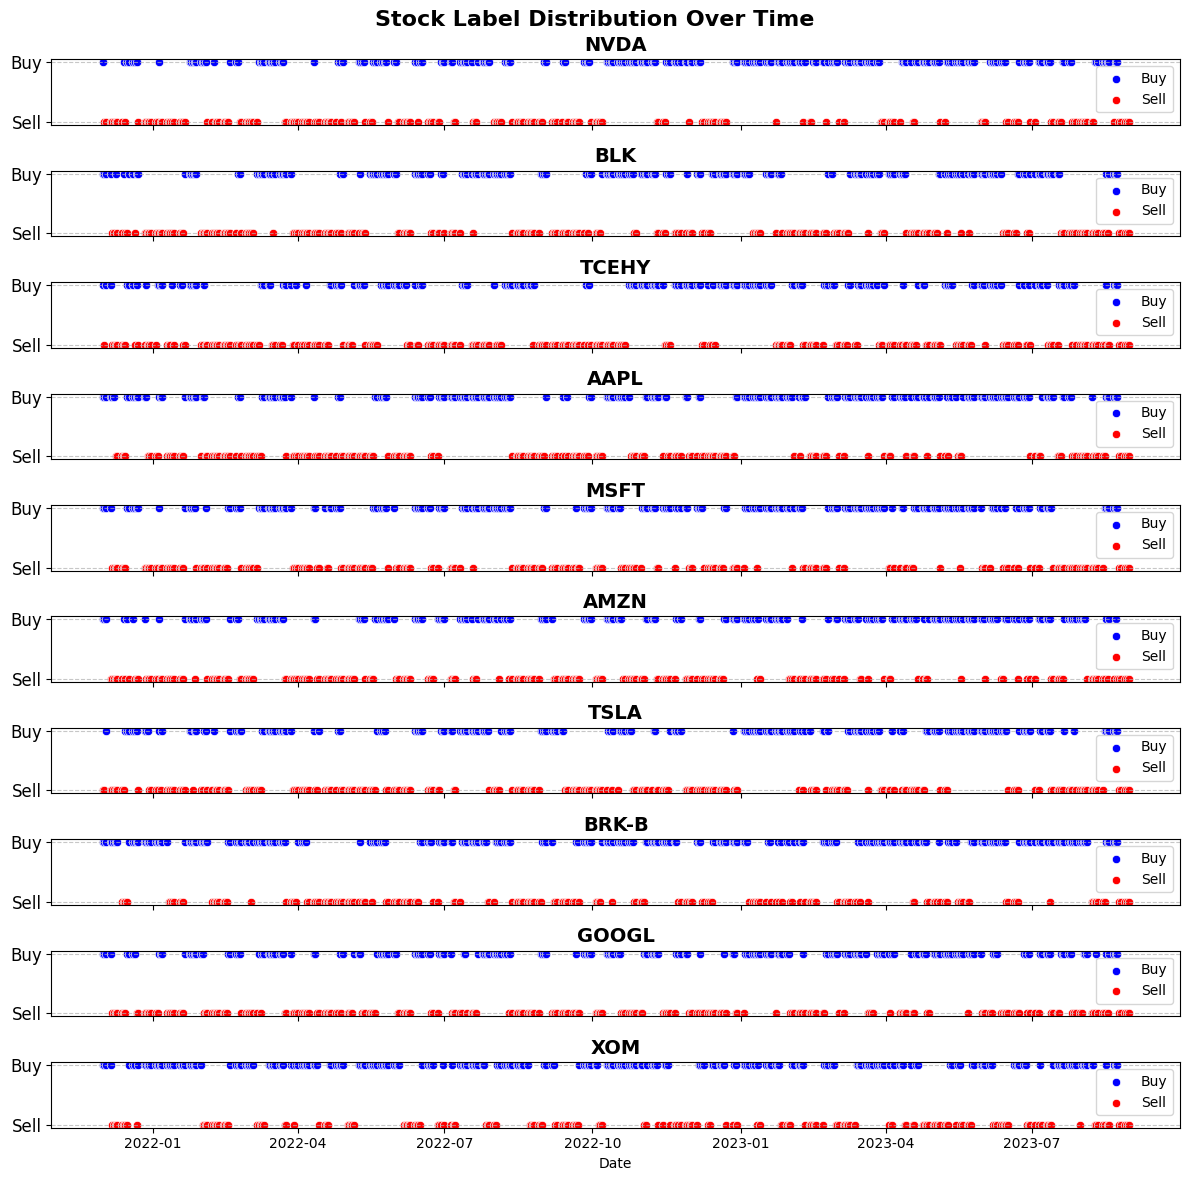

In [7]:
# Create a grid of subplots
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(12, 12), sharex=True)

# Define colors for Buy and Sell points
buy_color = 'blue'
sell_color = 'red'

for stock, stock_y_5d, ax in zip(tickers, y_5d, axes.flatten()):
    xs_up = stock_y_5d[stock_y_5d == 1].index
    ys_up = np.ones(len(xs_up))

    xs_down = stock_y_5d[stock_y_5d == 0].index
    ys_down = np.zeros(len(xs_down))

    # Use a single scatter plot with different colors for Buy and Sell
    sns.scatterplot(x=xs_up, y=ys_up, color=buy_color, label='Buy', ax=ax)
    sns.scatterplot(x=xs_down, y=ys_down, color=sell_color, label='Sell', ax=ax)

    ax.set_title(stock, fontsize=14, fontweight='bold')
    ax.set_yticks([0, 1])
    ax.set_yticklabels(labels=['Sell', 'Buy'], fontsize=12)

    # Add grid lines
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Set a title for the entire figure
fig.suptitle('Stock Label Distribution Over Time', fontsize=16, fontweight='bold')

# Add a legend
for ax in axes.flatten():
    ax.legend(fontsize=10)

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()


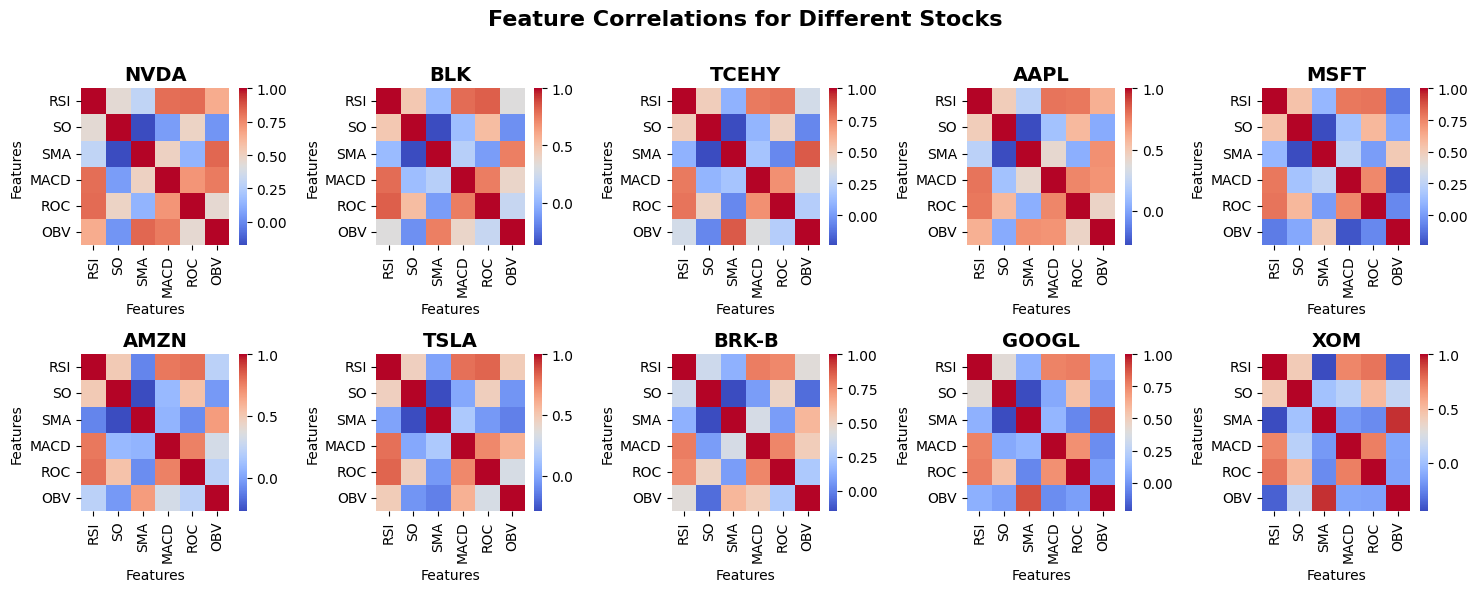

In [8]:
# Create a grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))

# Choose a colormap
cmap = "coolwarm"

for stock, stock_data, ax in zip(tickers, stocks, axes.flatten()):
    stock_X_5d = stock_data[feature_names]
    sns.heatmap(stock_X_5d.corr(), ax=ax, cmap=cmap, annot=False, cbar=True)
    ax.set_title(stock, fontsize=14, fontweight='bold')
    ax.tick_params(axis='both', which='both', labelsize=10)  # Increase label font size
    ax.set_xlabel('Features', fontsize=10)
    ax.set_ylabel('Features', fontsize=10)

# Set a title for the entire figure
fig.suptitle('Feature Correlations for Different Stocks', fontsize=16, fontweight='bold')

# Adjust layout
fig.tight_layout(rect=[0, 0, 1, 0.97])  # Leave space for the title

# Show the plot
plt.show()


# Machine Learning Model - Support Vector Machines

***************** 5 Day Period ***********
***************** 20 Day Period ***********


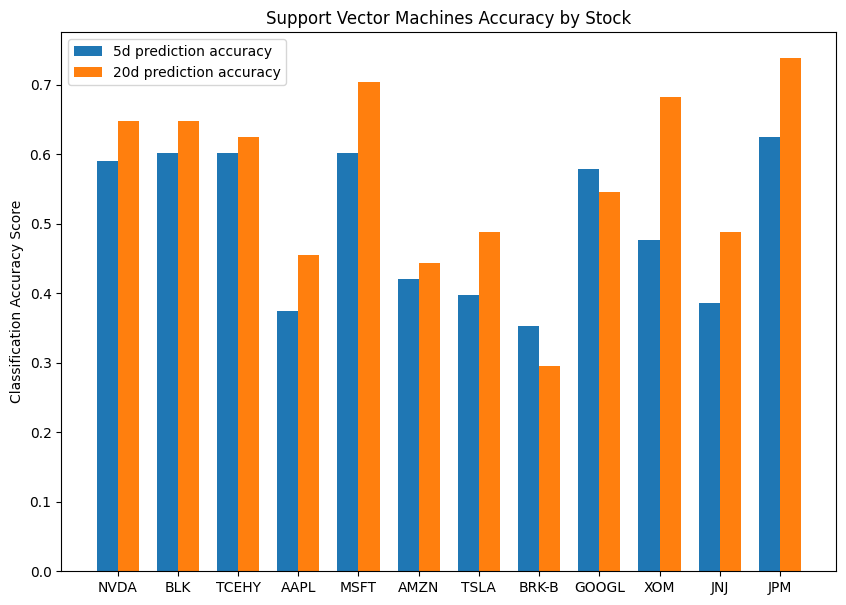

In [9]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import joblib

ts_cv_svc = TimeSeriesSplit(
    n_splits=5,  # Adjust the number of splits as needed
    gap=0,  # Set the gap parameter if required
)

# Function to train and evaluate SVM models
def train_evaluate_svm(X_train, y_train, X_test, y_test, param_grid):
    clf = GridSearchCV(SVC(probability=True, kernel="linear"), param_grid, refit=True, verbose=0, cv=ts_cv_svc)
    clf.fit(X_train, y_train)
    svm = clf.best_estimator_
    y_pred = svm.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=['down', 'up'], output_dict=True)
    confusion = confusion_matrix(y_true=y_test, y_pred=y_pred, normalize='true')
    feature_importances = svm.coef_
    all_features = dict(zip(feature_names, feature_importances[0]))
    sorted_features = sorted(all_features.items(), key=lambda x: x[1])

    return {
        'best_estimator': svm,
        'accuracy_score_test': accuracy,
        'classification_report': report,
        'confusion_matrix': confusion,
        'sorted_features': sorted_features,  # Store sorted_features here

    }

# Hyperparameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['linear']
}

# Train and evaluate SVM models for 5-day predictions
print("***************** 5 Day Period ***********")
stocks_metrics_5d = []
for i, stock in enumerate(stocks):
    X_train = X_train_5d[i]
    y_train = y_train_5d[i]
    X_test = X_test_5d[i]
    y_test = y_test_5d[i]

    result = train_evaluate_svm(X_train, y_train, X_test, y_test, param_grid)
    result['symbol'] = tickers[i]

    stocks_metrics_5d.append(result)

# Train and evaluate SVM models for 20-day predictions
print("***************** 20 Day Period ***********")
stocks_metrics_20d = []
for i, stock in enumerate(stocks):
    X_train = X_train_20d[i]
    y_train = y_train_20d[i]
    X_test = X_test_20d[i]
    y_test = y_test_20d[i]

    result = train_evaluate_svm(X_train, y_train, X_test, y_test, param_grid)
    result['symbol'] = tickers[i]

    stocks_metrics_20d.append(result)

# Save models using joblib
for i, metric in enumerate(stocks_metrics_5d):
    joblib.dump(metric['best_estimator'], f'model_5d_{tickers[i]}.joblib')

for i, metric in enumerate(stocks_metrics_20d):
    joblib.dump(metric['best_estimator'], f'model_20d_{tickers[i]}.joblib')

# Plotting accuracy scores
scores_5d_svc = [metric['accuracy_score_test'] for metric in stocks_metrics_5d]
scores_20d_svc = [metric['accuracy_score_test'] for metric in stocks_metrics_20d]

labels = tickers

x = np.arange(len(labels))
width = 0.35
plt.figure(figsize=(10, 7))
rects1 = plt.bar(x - width / 2, scores_5d_svc, width, label='5d prediction accuracy')
rects2 = plt.bar(x + width / 2, scores_20d_svc, width, label='20d prediction accuracy')

plt.ylabel('Classification Accuracy Score')
plt.title('Support Vector Machines Accuracy by Stock')
plt.xticks(x, labels)
plt.legend()
plt.show()





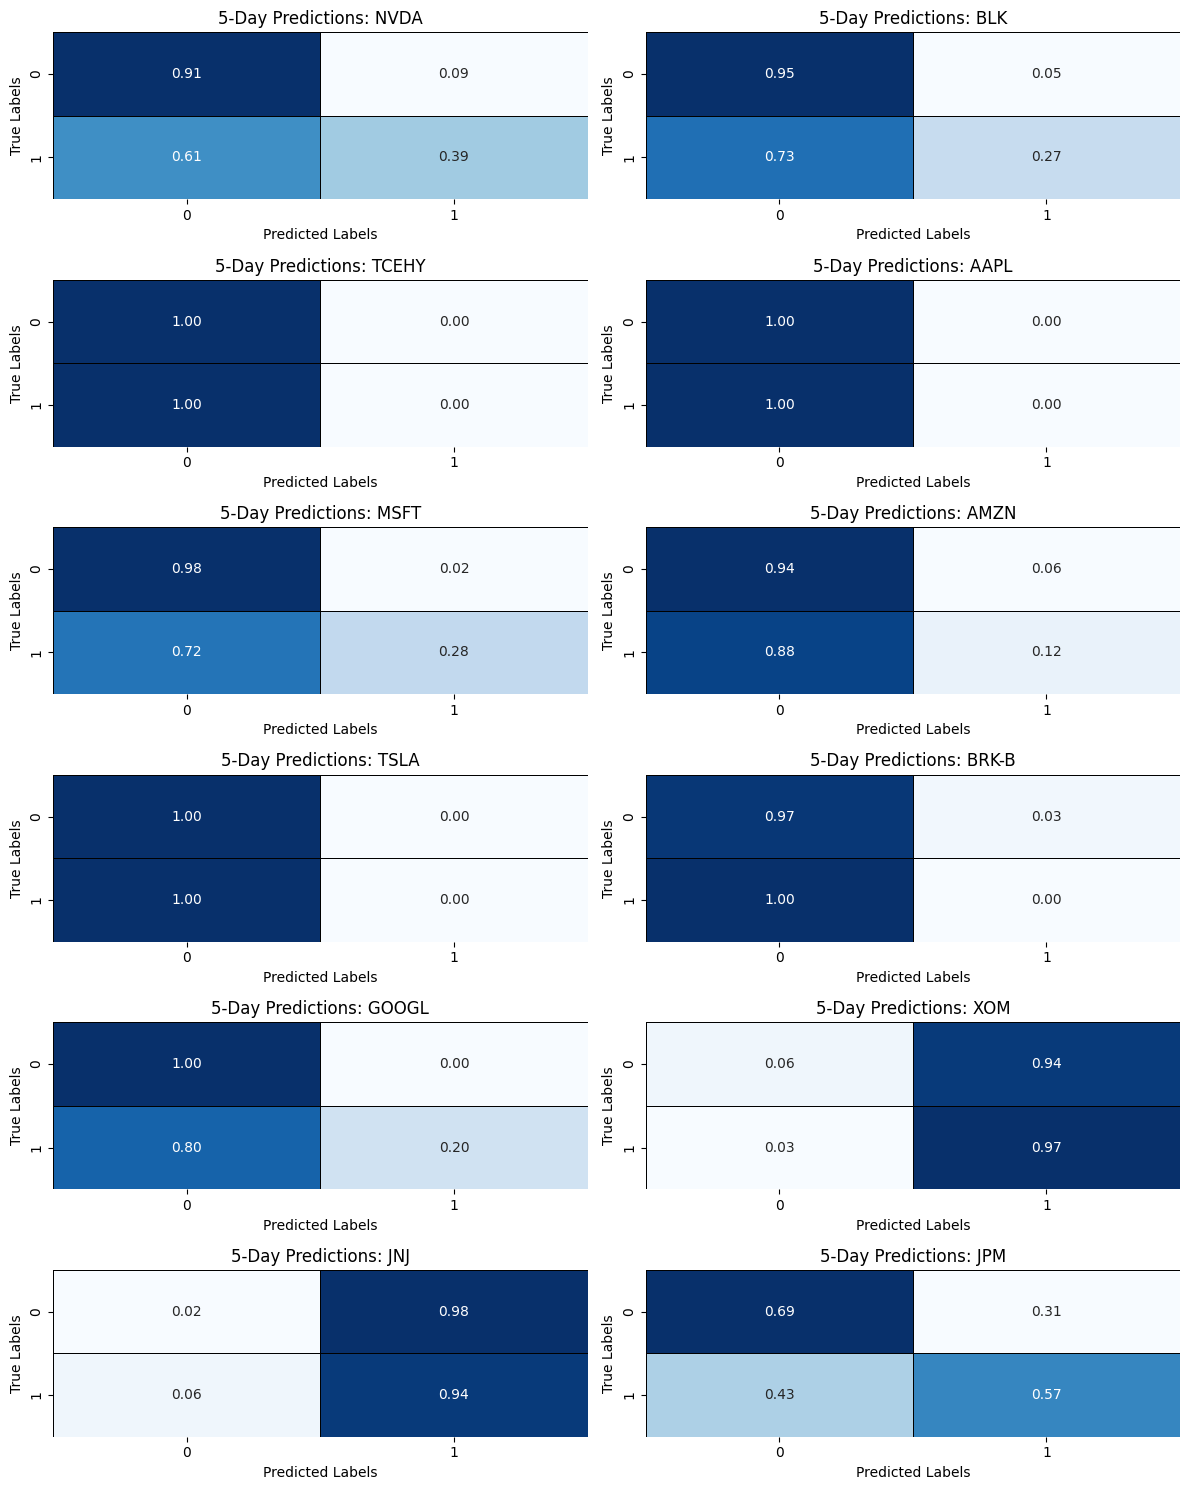

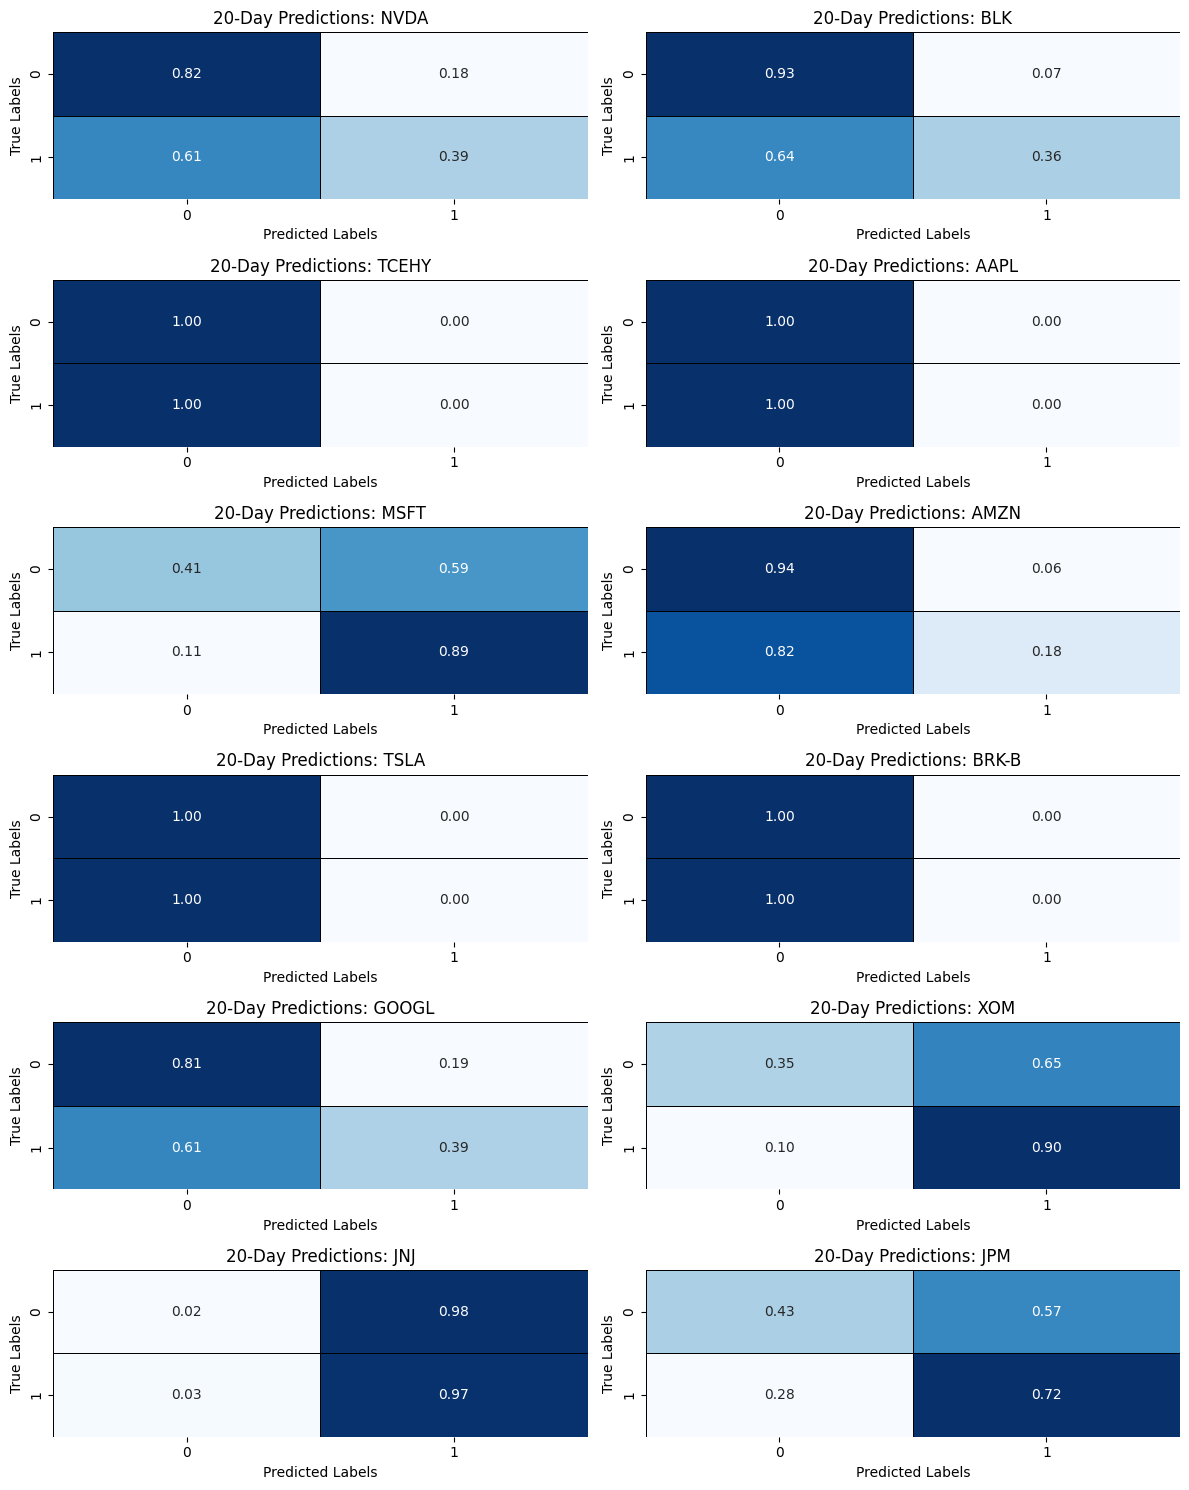

In [10]:
import seaborn as sns

def plot_confusion_matrices(models, labels, title_prefix):
    fig, axes = plt.subplots(nrows=len(models) // 2, ncols=2, figsize=(12, 15))
    cmap = plt.get_cmap('Blues')  # You can change the colormap as desired

    for i, (model, label) in enumerate(zip(models, labels)):
        y_pred = model.predict(X_test_5d[i])
        cm = confusion_matrix(y_test_5d[i], y_pred, normalize='true')

        sns.heatmap(
            cm,
            annot=True,
            fmt=".2f",
            cmap=cmap,
            cbar=False,
            ax=axes[i // 2, i % 2],
            linewidths=0.5,
            linecolor='black',
        )

        axes[i // 2, i % 2].set_title(title_prefix + " " + label)
        axes[i // 2, i % 2].set_xlabel("Predicted Labels")
        axes[i // 2, i % 2].set_ylabel("True Labels")

    plt.tight_layout()
    plt.show()

# Plot confusion matrices for 5-day predictions
plot_confusion_matrices([metric['best_estimator'] for metric in stocks_metrics_5d], tickers, "5-Day Predictions:")

# Plot confusion matrices for 20-day predictions
plot_confusion_matrices([metric['best_estimator'] for metric in stocks_metrics_20d], tickers, "20-Day Predictions:")


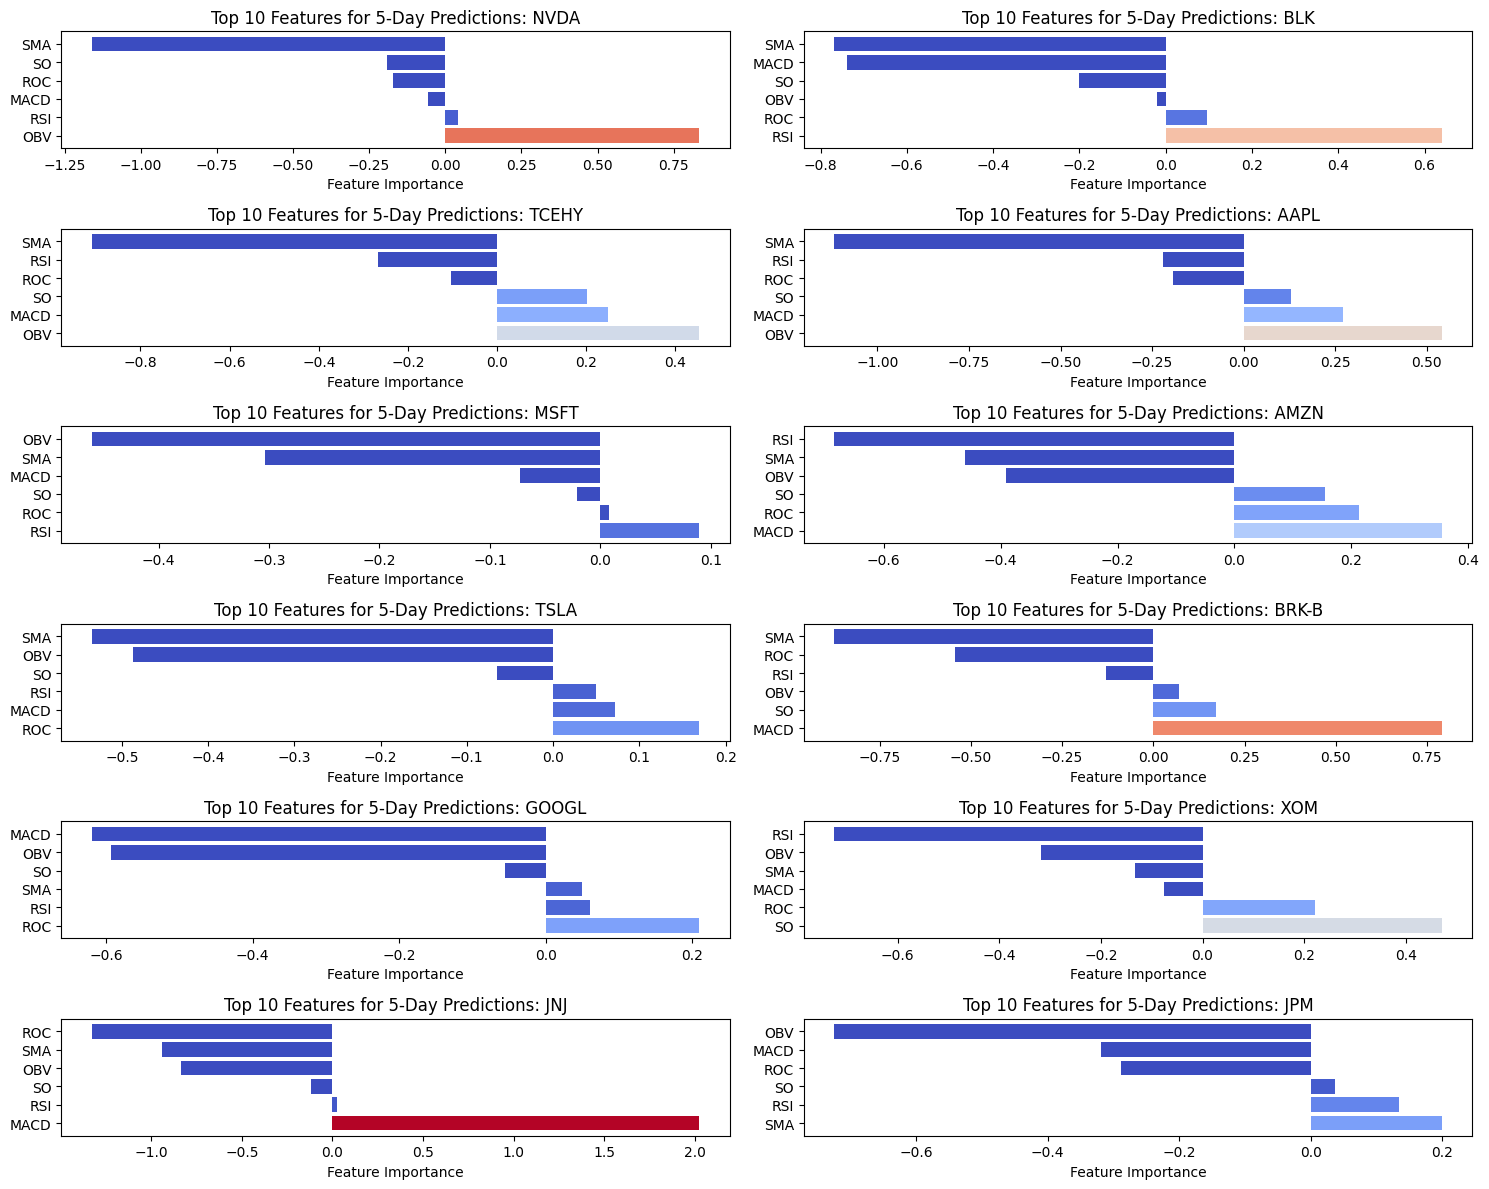

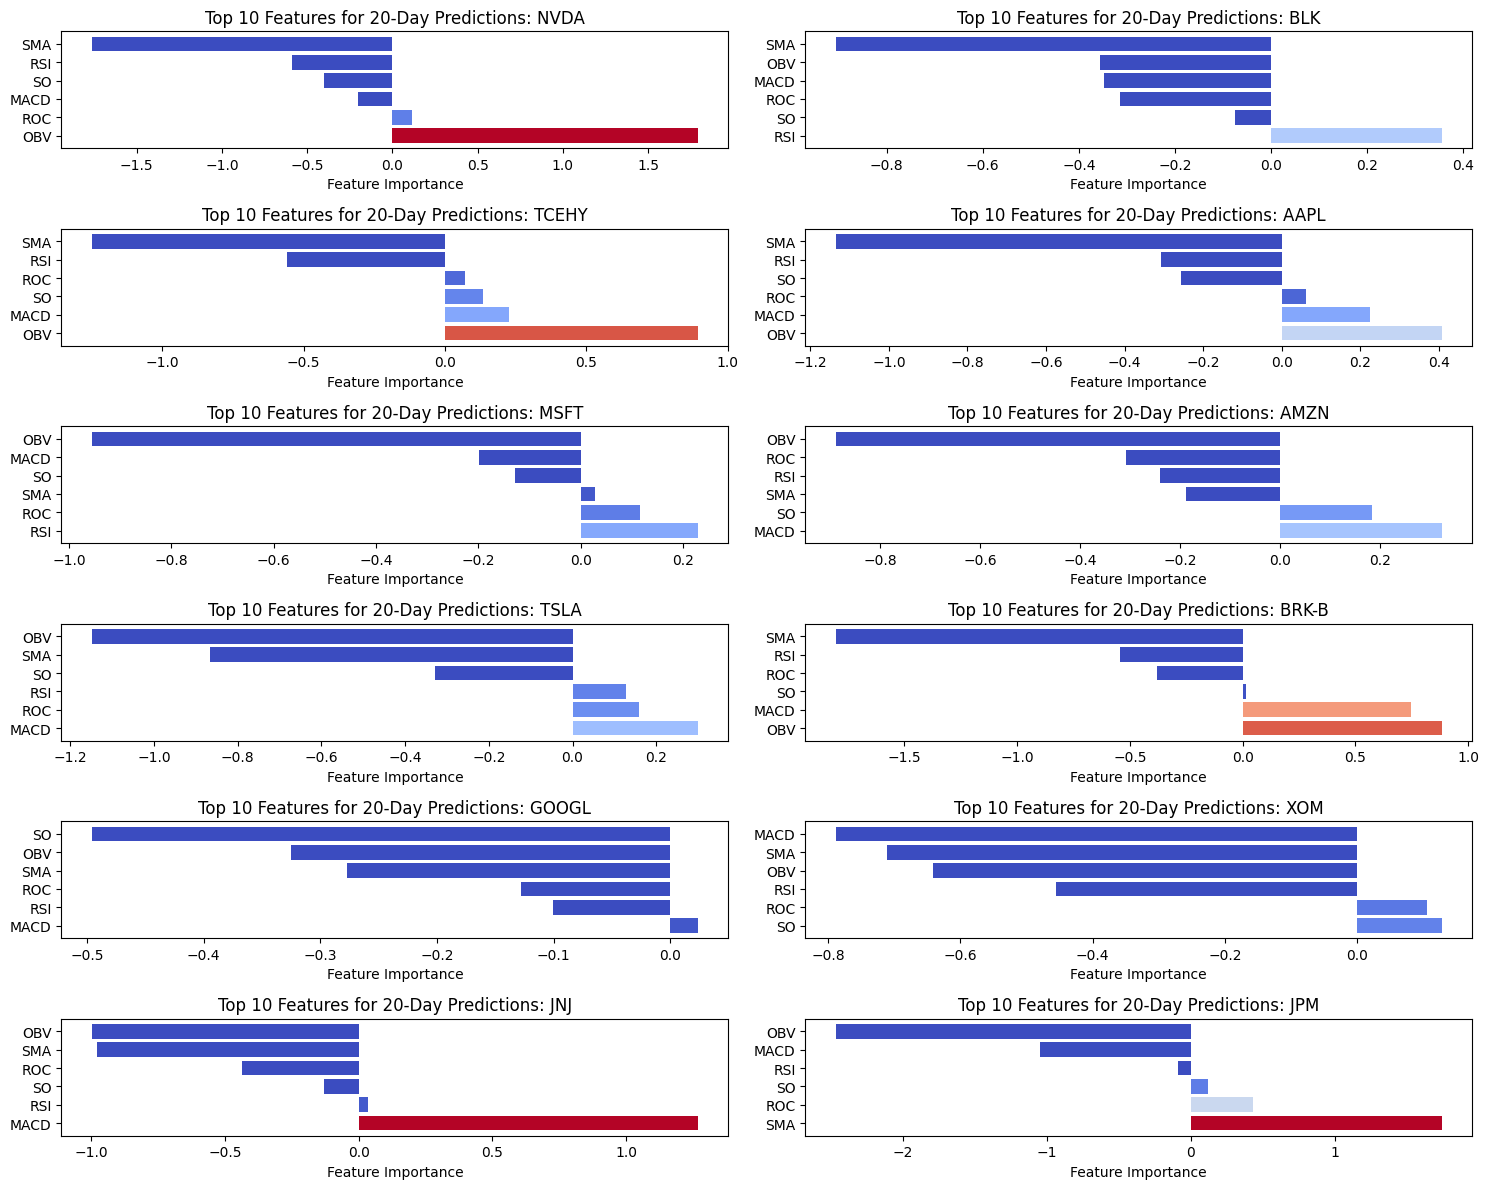

In [11]:
#Plotting Features importance

def plot_feature_importance(metrics, title_prefix, top_n=10):
    fig, axes = plt.subplots(nrows=len(metrics) // 2, ncols=2, figsize=(15, 12))
    cmap = plt.get_cmap('coolwarm')  # Use a diverging colormap

    for i, metric in enumerate(metrics):
        features = [f[0] for f in metric['sorted_features']]
        values = [f[1] for f in metric['sorted_features']]

        # Sort features by importance (descending)
        features = features[:top_n][::-1]
        values = values[:top_n][::-1]

        # Plot horizontal bar chart
        ax = axes[i // 2, i % 2]
        ax.barh(features, values, color=cmap(values))

        # Set labels and title
        ax.set_yticklabels(features, rotation=0)  # Rotate feature names for readability
        ax.set_xlabel('Feature Importance')
        ax.set_title(title_prefix + " " + metric['symbol'])

    plt.tight_layout()

# Plot the top 10 most important features for 5-day predictions
plot_feature_importance(stocks_metrics_5d, "Top 10 Features for 5-Day Predictions:", top_n=10)

# Plot the top 10 most important features for 20-day predictions
plot_feature_importance(stocks_metrics_20d, "Top 10 Features for 20-Day Predictions:", top_n=10)

plt.show()


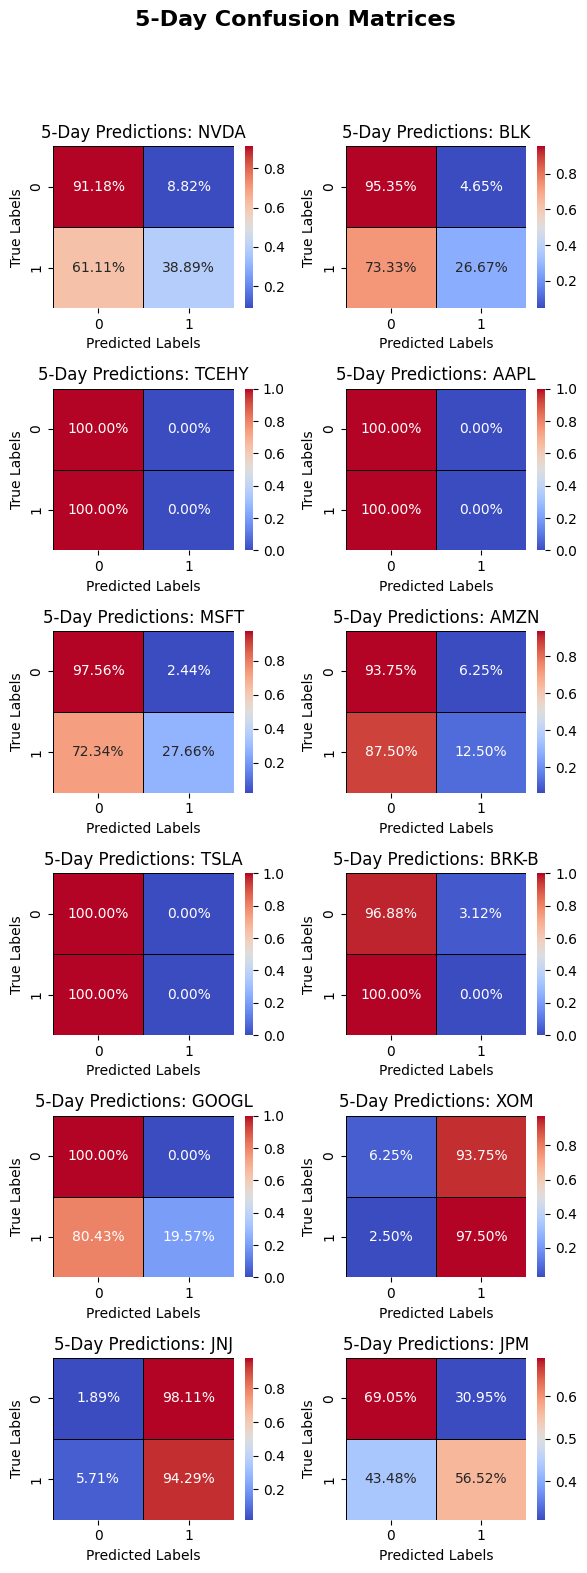

In [22]:
import seaborn as sns

def plot_confusion_matrices(models, labels, title_prefix):
    num_models = len(models)
    num_rows = (num_models + 1) // 2
    num_cols = 2

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(6, 16))
    cmap = plt.get_cmap('coolwarm')  # Use a consistent colormap

    for i, (model, label) in enumerate(zip(models, labels)):
        y_pred = model.predict(X_test_5d[i])
        cm = confusion_matrix(y_test_5d[i], y_pred, normalize='true')

        sns.heatmap(
            cm,
            annot=True,
            fmt=".2%",
            cmap=cmap,
            cbar=True,
            ax=axes[i // 2, i % 2],
            linewidths=0.5,
            linecolor='black',
        )

        axes[i // 2, i % 2].set_title(title_prefix + " " + label)
        axes[i // 2, i % 2].set_xlabel("Predicted Labels")
        axes[i // 2, i % 2].set_ylabel("True Labels")

    # Set a title for each row
    for ax_row in axes:
        row_title = ax_row[0].get_title()
        if row_title:
            fig.suptitle(row_title.split(' ')[0] + " Confusion Matrices", fontsize=16, fontweight='bold')
            break

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.94])  # Leave space for the title

    # Show the plot
    plt.show()

# Plot confusion matrices for 5-day predictions
plot_confusion_matrices([metric['best_estimator'] for metric in stocks_metrics_5d], tickers, "5-Day Predictions:")


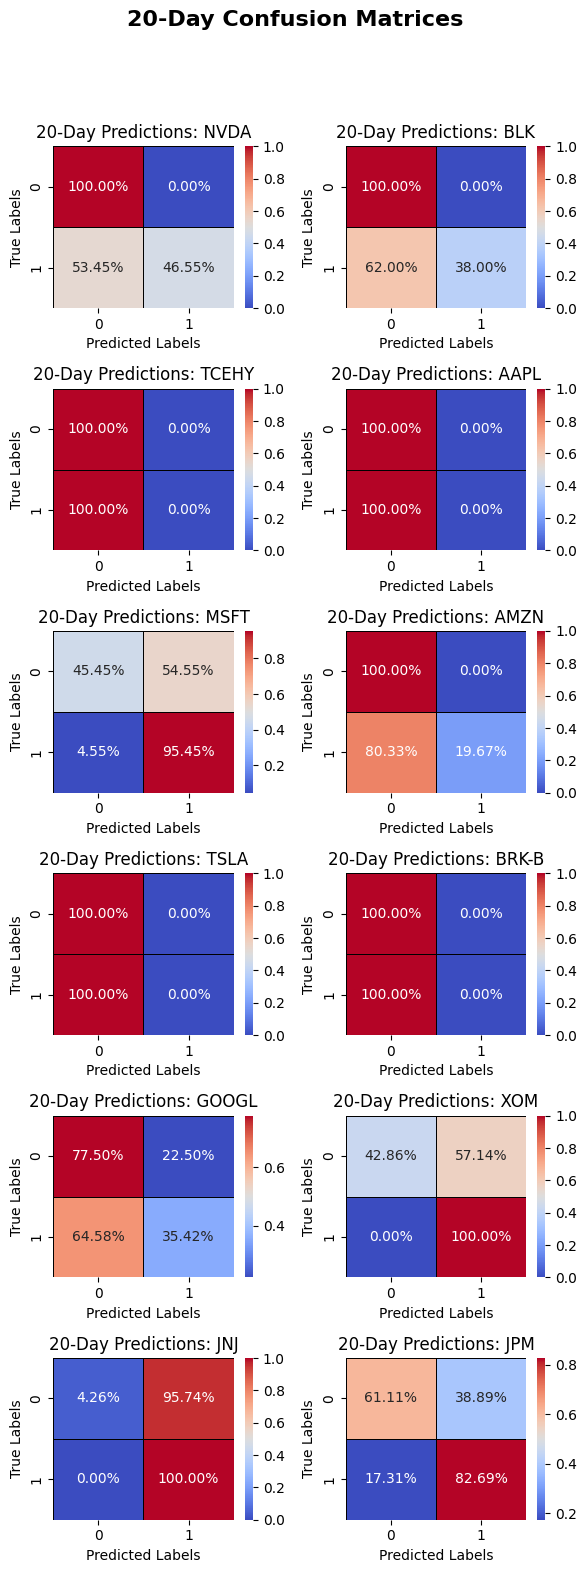

In [21]:
import seaborn as sns

def plot_confusion_matrices(models, labels, title_prefix):
    num_models = len(models)
    num_rows = (num_models + 1) // 2
    num_cols = 2

    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(6, 16))
    cmap = plt.get_cmap('coolwarm')  # Use a consistent colormap

    for i, (model, label) in enumerate(zip(models, labels)):
        y_pred = model.predict(X_test_20d[i])
        cm = confusion_matrix(y_test_20d[i], y_pred, normalize='true')

        sns.heatmap(
            cm,
            annot=True,
            fmt=".2%",
            cmap=cmap,
            cbar=True,
            ax=axes[i // 2, i % 2],
            linewidths=0.5,
            linecolor='black',
        )

        axes[i // 2, i % 2].set_title(title_prefix + " " + label)
        axes[i // 2, i % 2].set_xlabel("Predicted Labels")
        axes[i // 2, i % 2].set_ylabel("True Labels")

    # Set a title for each row
    for ax_row in axes:
        row_title = ax_row[0].get_title()
        if row_title:
            fig.suptitle(row_title.split(' ')[0] + " Confusion Matrices", fontsize=16, fontweight='bold')
            break

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.94])  # Leave space for the title

    # Show the plot
    plt.show()

# Plot confusion matrices for 20-day predictions
plot_confusion_matrices([metric['best_estimator'] for metric in stocks_metrics_20d], tickers, "20-Day Predictions:")


In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

models_random_forest_5d = []
models_random_forest_20d = []
scores_5d = []
scores_20d = []

# Define hyperparameters for grid search
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 8],
    'max_features': [4, 8]
}

# Define a function to train and evaluate the Random Forest model
def train_evaluate_rf(X_train, y_train, X_test, y_test, ticker, prediction_period):
    print(f'{prediction_period}-Day Random Forest Training and Evaluation for {ticker}:')

    # Create a Random Forest Classifier
    rf = RandomForestClassifier(random_state=42)

    # Perform a grid search to find the best hyperparameters
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)

    # Get the best estimator from the grid search
    best_rf = grid_search.best_estimator_

    # Fit the model on the training data
    best_rf.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = best_rf.predict(X_test)

    # Calculate and print the accuracy score
    accuracy = accuracy_score(y_test, y_pred, normalize=True) * 100.0
    print(f'Accuracy (%) for {prediction_period}-Day Prediction: {accuracy:.2f}')

    # Append the model and score to the respective lists
    if prediction_period == 5:
        models_random_forest_5d.append(best_rf)
        scores_5d.append(accuracy)
    elif prediction_period == 20:
        models_random_forest_20d.append(best_rf)
        scores_20d.append(accuracy)

# Iterate over stocks for both 5-day and 20-day predictions
for i, stock in enumerate(stocks):
    ticker = tickers[i]

    # 5-Day Predictions
    X_train_5d_i = X_train_5d[i]
    y_train_5d_i = y_train_5d[i]
    X_test_5d_i = X_test_5d[i]
    y_test_5d_i = y_test_5d[i]

    if len(X_train_5d_i) == 0 or len(y_train_5d_i) == 0:
        print(f'Skipping {ticker} for 5-day prediction due to empty data.')
    else:
        train_evaluate_rf(X_train_5d_i, y_train_5d_i, X_test_5d_i, y_test_5d_i, ticker, prediction_period=5)

    # 20-Day Predictions
    X_train_20d_i = X_train_20d[i]
    y_train_20d_i = y_train_20d[i]
    X_test_20d_i = X_test_20d[i]
    y_test_20d_i = y_test_20d[i]

    if len(X_train_20d_i) == 0 or len(y_train_20d_i) == 0:
        print(f'Skipping {ticker} for 20-day prediction due to empty data.')
    else:
        train_evaluate_rf(X_train_20d_i, y_train_20d_i, X_test_20d_i, y_test_20d_i, ticker, prediction_period=20)

# Display the results
print("\n5-Day Prediction Accuracy Scores:")
for ticker, score_5d in zip(tickers, scores_5d):
    print(f'{ticker}: {score_5d:.2f}%')

print("\n20-Day Prediction Accuracy Scores:")
for ticker, score_20d in zip(tickers, scores_20d):
    print(f'{ticker}: {score_20d:.2f}%')


IndexError: ignored